In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [7]:
# Load QB data
qb = pd.read_csv("dat/qb_stats.csv")

# Drop non-predictive columns
qb_features = qb.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'full_name', 'total_epa', 'third_down_rate', 'fourth_down_rate'])
qb_features = pd.get_dummies(qb_features, columns=['team'])
qb_features



,season,week,birth_date,height,weight,years_exp,rookie_year,entry_year,draft_number,pass_attempts,...,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS
0,2018,1,1977-08-03,76,225,18,2000,2000,199.0,41,...,False,False,False,False,False,False,False,False,False,False
1,2018,1,1979-01-15,72,209,17,2001,2001,32.0,47,...,False,False,False,False,False,False,False,False,False,False
2,2018,1,1981-01-03,77,218,14,2004,2004,1.0,39,...,True,False,False,False,False,False,False,False,False,False
3,2018,1,1982-03-02,77,240,14,2004,2004,11.0,45,...,False,False,False,False,True,False,False,False,False,False
4,2018,1,1981-12-08,77,228,14,2004,2004,4.0,54,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,2023,21,1995-09-17,74,230,6,2017,2017,10.0,41,...,False,False,False,False,False,False,False,False,False,False
3991,2023,21,1997-01-07,74,212,5,2018,2018,32.0,41,...,False,False,False,False,False,False,False,False,False,False
3992,2023,21,1999-12-27,73,212,1,2022,2022,262.0,33,...,False,False,False,False,False,False,True,False,False,False
3993,2023,22,1995-09-17,74,230,6,2017,2017,10.0,49,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# Converting player birth_date to datetime and extracting birth_year
qb_features['birth_date'] = pd.to_datetime(qb_features['birth_date'])
qb_features['birth_year'] = qb_features['birth_date'].dt.year
qb_features = qb_features.drop(columns=['birth_date']) # Birth month and birth day are not as relevant as birth year
qb_features


,season,week,height,weight,years_exp,rookie_year,entry_year,draft_number,pass_attempts,air_yards,...,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,birth_year
0,2018,1,76,225,18,2000,2000,199.0,41,184,...,False,False,False,False,False,False,False,False,False,1977
1,2018,1,72,209,17,2001,2001,32.0,47,272,...,False,False,False,False,False,False,False,False,False,1979
2,2018,1,77,218,14,2004,2004,1.0,39,138,...,False,False,False,False,False,False,False,False,False,1981
3,2018,1,77,240,14,2004,2004,11.0,45,122,...,False,False,False,True,False,False,False,False,False,1982
4,2018,1,77,228,14,2004,2004,4.0,54,175,...,False,False,False,False,False,False,False,False,False,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,2023,21,74,230,6,2017,2017,10.0,41,122,...,False,False,False,False,False,False,False,False,False,1995
3991,2023,21,74,212,5,2018,2018,32.0,41,139,...,False,False,False,False,False,False,False,False,False,1997
3992,2023,21,73,212,1,2022,2022,262.0,33,146,...,False,False,False,False,False,True,False,False,False,1999
3993,2023,22,74,230,6,2017,2017,10.0,49,149,...,False,False,False,False,False,False,False,False,False,1995


In [9]:
# Drop rows with missing values
qb_features = qb_features.dropna()
qb_labels = qb.loc[qb_features.index, 'avg_epa']
qb_labels


0       0.113338
1       0.376662
2      -0.305159
3      -0.076453
4       0.298481
          ...   
3988   -0.145339
3989    0.162754
3990    0.147117
3991   -0.170512
3992    0.309381
Name: avg_epa, Length: 3054, dtype: float64

In [10]:
print(qb_features.shape, qb_labels.shape)

(3054, 79) (3054,)


QB RMSE: 0.13329838078424905
QB R2: 0.7874430759378129
Cross-validated RMSE: 0.136 ± 0.006
Cross-validated R²: 0.787 ± 0.025


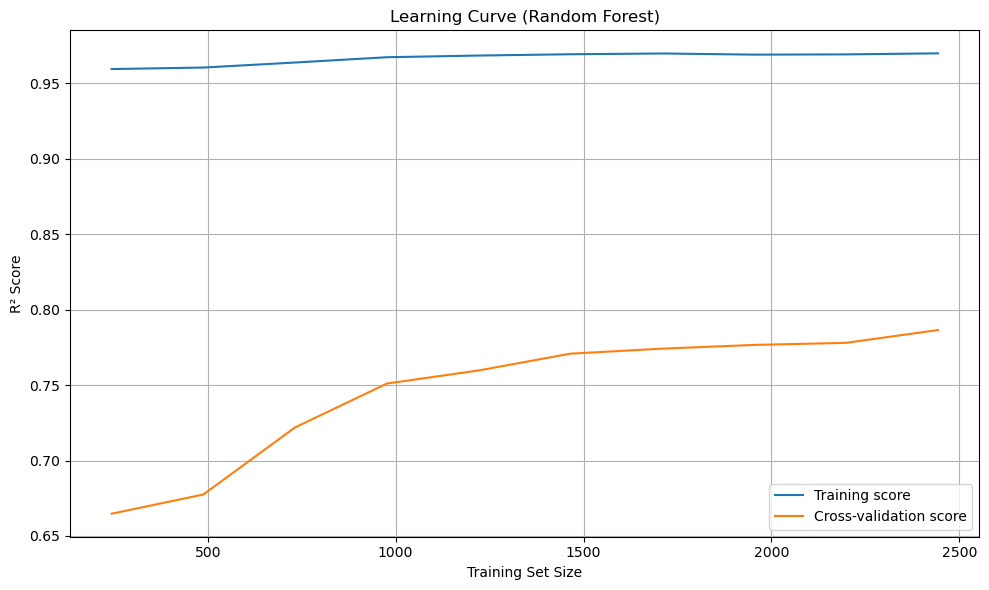

pass_touchdowns         0.225813
cpoe                    0.162458
third_down_failed       0.121204
interceptions           0.066174
pass_yards              0.060453
first_down_pass         0.045092
sack                    0.028169
fumble_lost             0.027910
fourth_down_failed      0.024528
third_down_converted    0.020473
dtype: float64
                               min          max
season                 2018.000000  2023.000000
rookie_year            2000.000000  2023.000000
entry_year             2000.000000  2023.000000
birth_year             1977.000000  2002.000000
pass_yards               25.000000   525.000000
air_yards               -15.000000   344.000000
draft_number              1.000000   262.000000
weight                  194.000000   245.000000
rushing_yards            -6.000000   178.000000
completion_percentage    23.809524    96.666667


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(qb_features, qb_labels, test_size=0.2, random_state=42)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Align your labels
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]
# Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
root_mean_squared_error = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
print("QB RMSE:", root_mean_squared_error(y_test, y_pred))
print("QB R2:", r2_score(y_test, y_pred))

# Cross-validation
cv_rmse_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42), qb_features, qb_labels, cv=5, scoring='neg_root_mean_squared_error')
cv_r2_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42), qb_features, qb_labels, cv=5, scoring='r2')
print(f"Cross-validated RMSE: {-cv_rmse_scores.mean():.3f} ± {cv_rmse_scores.std():.3f}")
print(f"Cross-validated R²: {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(n_estimators=100, random_state=42),
    qb_features, qb_labels,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=qb_features.columns).sort_values(ascending=False)
print(feature_importance.head(10))

print(X_train.describe().T[['min', 'max']].sort_values('max', ascending=False).head(10))

In [ ]:
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(qb_features, qb_labels, test_size=0.2, random_state=42)

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Drop rows with NaNs
# X_train.dropna(inplace=True)
# X_test.dropna(inplace=True)

# # Align your labels
# y_train = y_train.loc[X_train.index]
# y_test = y_test.loc[X_test.index]

# # Model: Random Forest
# rf_qb = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_qb.fit(X_train, y_train)

# # Evaluate
# y_pred = rf_qb.predict(X_test)
# print("QB RMSE:", root_mean_squared_error(y_test, y_pred))
# print("QB R2:", r2_score(y_test, y_pred))

# # Feature importance
# feature_importance = pd.Series(rf_qb.feature_importances_, index=qb_features.columns).sort_values(ascending=False)
# print(feature_importance.head(10))

QB RMSE: 0.13329838078424905
QB R2: 0.7874430759378129
pass_touchdowns         0.225813
cpoe                    0.162458
third_down_failed       0.121204
interceptions           0.066174
pass_yards              0.060453
first_down_pass         0.045092
sack                    0.028169
fumble_lost             0.027910
fourth_down_failed      0.024528
third_down_converted    0.020473
dtype: float64


In [12]:
print(X_train.describe().T[['min', 'max']].sort_values('max', ascending=False).head(10))

                               min          max
season                 2018.000000  2023.000000
rookie_year            2000.000000  2023.000000
entry_year             2000.000000  2023.000000
birth_year             1977.000000  2002.000000
pass_yards               25.000000   525.000000
air_yards               -15.000000   344.000000
draft_number              1.000000   262.000000
weight                  194.000000   245.000000
rushing_yards            -6.000000   178.000000
completion_percentage    23.809524    96.666667


In [ ]:
X_train

,season,week,height,weight,years_exp,rookie_year,entry_year,draft_number,pass_attempts,completions,...,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,birth_year
562,2018,7,76,218,0,2018,2018,10.0,45,21,...,False,False,False,False,False,False,False,False,False,1997
1092,2019,3,76,226,1,2018,2018,10.0,42,18,...,False,False,False,False,False,False,False,False,False,1997
168,2018,8,75,220,9,2009,2009,1.0,43,27,...,False,False,False,False,False,False,False,False,False,1988
2722,2023,3,75,210,9,2014,2014,36.0,21,13,...,False,False,False,False,False,False,False,False,False,1991
2214,2021,18,75,220,6,2015,2015,250.0,16,9,...,False,False,False,False,False,False,False,False,False,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2021,6,77,240,17,2004,2004,11.0,41,29,...,False,False,False,True,False,False,False,False,False,1982
1326,2020,17,77,228,16,2004,2004,4.0,28,17,...,False,False,False,False,False,False,False,False,False,1981
1361,2020,3,74,228,15,2005,2005,250.0,21,18,...,False,False,False,False,False,False,False,False,False,1982
1538,2020,1,75,210,6,2014,2014,36.0,30,22,...,False,False,False,False,False,False,False,False,False,1991
